# K.P model for Weyl fermions

In this tutorial we wil investigate the properties of a Weyl Hamiltonian

# First, import needed modules

In [ ]:
# So, first import the necessary modules

import wannierberri as wberri
print (f"Using WannierBerri version {wberri.__version__}")
import pythtb
import numpy as np
import matplotlib.pyplot as plt

## Define Parallel environment

In [ ]:
#  This block is needed if you run this cell for a second time
#  because one cannot initiate two parallel environments at a time
try:
    parallel.shutdown()
except NameError:
    pass

# Chiose one of the options:

#parallel = wberri.Parallel(num_cpus=2)
#parallel = wberri.Parallel()  # automatic detection
parallel = wberri.Serial()

## Free-electron k.p model

For simplicity, it is a 1-band free-electron

In [ ]:
# hamiltonian takes k-vector in reciprocal angstroms and gives hamiltonian in eV
mass = 1.5   # in units Ang^2/eV
def ham(k):
    return np.array([[np.dot(k,k)/(2*mass)]])
# k.p model is bounded to a box of size 2*kmax
system_kp = wberri.system.SystemKP(Ham=ham, kmax=2)

In [ ]:
path=wberri.Path(system_kp,
                 k_nodes=[
        [0.0000, 0.0000, 0.0000 ],   #  G
        [1.0 ,1.0, 1.0],   #  G
        [0.0, 1.0, 1.0],   #  G
        [0.0,1.0,0.0]   #  G
                 ] ,
                 labels=["G0","G111","G011","G010"],
                 length=200 )   # length [ Ang] ~= 2*pi/dk

tabulators = { "Energy": wberri.calculators.tabulate.Energy(),
             }

tab_all_path = wberri.calculators.TabulatorAll(
                    tabulators,
                    # ibands = np.arange(0,18),
                    mode = "path"
                        )

In [ ]:
result=wberri.run(system_kp,
                  grid=path,
                  calculators = {"tabulate" : tab_all_path},
                  parallel = parallel,
                  print_Kpoints = False)

print (result.results)
path_result = result.results["tabulate"]

## Plot bands

The `TABresult` object already provides methods to plot the results. (As well as one can extract the data and plot them by other means). Below let’s plot the interpolated bands and compare with those obtained in QE. (file “bands/Fe_bands_pw.dat” is already provided)

In [ ]:
path_result = result.results["tabulate"]

plt.close()
path_result.plot_path_fat( path,
              quantity=None,
#              Eshift=EF,
              Emin=-2,  Emax=5,
              iband=None,
              mode="fatband",
              fatfactor=20,
              cut_k=False,
              close_fig=False,
              show_fig=False,
              label = "WB"
              )

kline = path.getKline()
plt.plot(kline,kline**2/(2*mass),"--",label="k**2/(2*mass)")

plt.legend()
plt.show()
plt.close()

In [ ]:
Efermi = np.linspace(-1,2,201)
calculators = {"dos":wberri.calculators.static.DOS(
                    Efermi=Efermi, # Fermi levels to scan
                    tetra=True  # use tetahedron integration method
                        )}
grid = wberri.Grid(system_kp, NK=20, NKFFT=10 )
result_run = wberri.run(system_kp,
            grid=grid,
            calculators = calculators,
            parallel=parallel,
            adpt_num_iter=0,
            fout_name='kp',
            restart=False,
            #print_Kpoints=False
            #file_Klist="Klist_ahc.pickle"  # needed to restart a calculation in future
            )

# Plot the DOS and compare with the analytical value
For free-electron energies
$$\varepsilon(k)=\frac{k^2}{2m}$$
The DOS can be evaluated analytically
$${\rm DOS}(E_F) = \int \frac{d^3k}{(2\pi)^3} \delta(E-\varepsilon(k)) = \frac{4\pi}{(2\pi)^3}\int k^2 dk \delta(E-k^2/(2m)) = \frac{1}{2\pi^2} \int dk k\delta(k-\sqrt{2mE_F}) = \frac{\sqrt{2mE_F}}{2\pi^2}$$

In [ ]:
dos = result_run.results["dos"].data
plt.plot(Efermi,dos)
plt.ylim(0,1)

Efpos=Efermi[Efermi>0.01]

dos_prec = np.sqrt(2*mass*Efpos)*system_kp.cell_volume*mass/(2*np.pi**2)

plt.plot(Efpos,dos_prec,"--")


# Now, the Weyl Hamiltonian

In [ ]:
sigma_x = np.array([[ 0, 1],
                    [1, 0]])
sigma_y = np.array([[ 0, -1j],
                    [1j, 0]])
sigma_z = np.array([[-1, 0],
                    [ 0, 1]])

v=2 # in units eV*Ang
vx=v
vy=v
vz=v


def Ham_Weyl(k):
    return vx*k[0]*sigma_x + vy*k[1]*sigma_y + vz*k[2]*sigma_z

kmax_weyl=0.2
system_weyl = wberri.system.SystemKP(Ham=Ham_Weyl, kmax=kmax_weyl)
system_weyl.set_symmetry(["C4x","C4y","C4z","TimeReversal"])

In [ ]:
direction = np.array([0,0.0,0.1])/(2*kmax_weyl)  # Note, that k-points are given to path in reciprocal coordinates
path=wberri.Path(system_weyl,
                 k_nodes=[
        -direction,   #  
        [0 ,0, 0],   #  
        direction,   #  
                 ] ,
                 labels=["-kz","0","+kz"],
                 nk=20 )  

tabulators = { "Energy": wberri.calculators.tabulate.Energy(),
               "berry": wberri.calculators.tabulate.BerryCurvature(kwargs_formula={"external_terms":False}),
             }

tab_all_path = wberri.calculators.TabulatorAll(
                    tabulators,
                    # ibands = np.arange(0,18),
                    mode = "path"
                        )

result=wberri.run(system_weyl,
                  grid=path,
                  calculators = {"tabulate" : tab_all_path},
                  parallel = parallel,
                  print_Kpoints = False)

print (result.results)
path_result = result.results["tabulate"]

In [ ]:
for component in "xyz":
    path_result.plot_path_fat( path,
              quantity="berry",
                component=component,
        #save_file="Fe_bands+QE.pdf",
#              Eshift=EF,
     #         Emin=-0.05,  Emax=0.05,
              iband=None,
              mode="fatband",
              fatfactor=30,
              cut_k=False,
              close_fig=True,
              show_fig=True,
              label = "berry_"+component
              )

In [ ]:
berry_curv = path_result.get_data("berry",iband=(0,1))
kline = path.getKline()
kline-=kline.mean()
#berry_curv.shape
plt.scatter(kline,berry_curv[:,0,2],label="lower bandberry_z")
plt.scatter(kline,berry_curv[:,1,2],label="pper bandberry_z")
plt.plot(kline,0.5/kline**2,"--",label=r"1/(2$k^2$)")
plt.plot(kline,-0.5/kline**2,"--",label=r"-1/(2$k^2)$")

plt.ylim(-5000,5000)
plt.legend()

In [ ]:
Efermi_Weyl = np.linspace(-0.1,0.1,201)
Efermi=Efermi_Weyl
calculators = {
               "dos":wberri.calculators.static.DOS(Efermi=Efermi,tetra=True),
               "berry_dipole_surf":wberri.calculators.static.BerryDipole_FermiSurf(Efermi=Efermi,tetra=True,kwargs_formula={"external_terms":False}),
               #"berry_dipole_sea":wberri.calculators.static.BerryDipole_FermiSea(Efermi=Efermi,tetra=True,kwargs_formula={"external_terms":False})
}

system_weyl.set_symmetry(["C4x","C4y","C4z","TimeReversal"])

result={}
for NK in 20,30,40:
    grid = wberri.Grid(system_weyl, NK=NK, NKFFT=5 )
    result[NK] = wberri.run(system_weyl,
            grid=grid,
            calculators = calculators,
            parallel=parallel,
             adpt_num_iter=20,
            fout_name='Weyl',
            )
    BD = result[NK].results["berry_dipole_surf"].data
    plt.plot(Efermi,BD[:,2,2]*3,".",label = f"NK={NK}")
    plt.legend()


In [ ]:
for NK in 20,30,40:
    BD = result[NK].results["berry_dipole_surf"].data
    BD_trace=BD[:,0,0]+BD[:,1,1]+BD[:,2,2]
    plt.plot(Efermi,BD_trace,".",label = f"NK={NK}")
    plt.hlines(1/(4*np.pi**2),xmin=-0.1,xmax=0.1)
    plt.legend()

In [ ]:
plt.close()
ahc = result_run.results["ahc"].data[:,2]
plt.plot(Efermi,ahc)

In [ ]:
# The 2D conductance in the gap is 
ahc[Efermi_haldane==0]*system_haldane.real_lattice[2,2]*1e-10

In [ ]:
# This is precisely half of conductance quantum
from scipy.constants import physical_constants as pc
[k for k in pc.keys() if "conduc" in k]
pc['conductance quantum']
pc['conductance quantum'][0]/2


# Quantized circular photogavlanic efect

https://www.nature.com/articles/ncomms15995

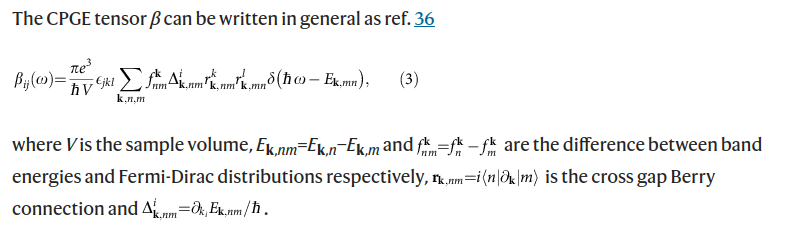

In [ ]:
from  wannierberri.symmetry import transform_ident, transform_odd
from wannierberri.calculators.dynamic import DynamicCalculator

class CPGE_Formula():
    """
    Eq. (10) of Lihm and Park, PRB 105, 045201 (2022)
    Use v_mn = i * r_mn * (e_m - e_n) / hbar to replace v with r.
    """

    def __init__(self, data_K,external_terms=True):
        if external_terms:
            A_H = data_K.A_H
        else:
            A_H = data_K.A_H_internal
        V_H = data_K.Xbar('Ham', 1) # (k, m, n, a)
        V_H_diag = np.diagonal(V_H, axis1=1, axis2=2).transpose(0, 2, 1) # (k, m, a)

        # compute delta_V[k, m, n, a] = V_H[k, m, m, a] - V_H[k, n, n, a]
        delta_V = V_H_diag[:, :, None, :] - V_H_diag[:, None, :, :] # (k, m, n, a)

        Imn_abc = np.einsum('kmna,kmnb,knmc->kmnabc', delta_V, A_H, A_H)
        Imn = Imn_abc[:,:,:,:,[1,2,0],[2,0,1]]-Imn_abc[:,:,:,:,[2,0,1],[1,2,0]]
      #  print ("trImn=",sum([Imn[:,:,:,i,i].imag for i in (0,1,2)]))
      #  print ("deltaV=",np.linalg.norm(delta_V,axis=3))
      #  Imn=
        self.Imn = sum([Imn[:,:,:,i,i] for i in (0,1,2)])
        self.ndim = 1j

    def trace_ln(self, ik, inn1, inn2):
        return self.Imn[ik, inn1].sum(axis=0)[inn2].sum(axis=0)


class CPGE(DynamicCalculator):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.Formula = CPGE_Formula
        self.transformTR  = transform_ident
        self.transformInv = transform_odd
        self.constant_factor = 1


    def factor_omega(self, E1, E2):
        delta_arg_12 = E1 - E2 - self.omega  # argument of delta function [iw, n, m]
        return self.smear(delta_arg_12)

In [ ]:
Efermi_Weyl = np.array([0.025])
omega = np.linspace(0,0.1,100)
Efermi=Efermi_Weyl
calculators = {
           #    "dos":wberri.calculators.static.DOS(Efermi=Efermi,tetra=True),
            #   "berry_dipole_surf":wberri.calculators.static.BerryDipole_FermiSurf(Efermi=Efermi,tetra=True,kwargs_formula={"external_terms":False}),
               #"berry_dipole_sea":wberri.calculators.static.BerryDipole_FermiSea(Efermi=Efermi,tetra=True,kwargs_formula={"external_terms":False})
         "cpge": CPGE(Efermi=Efermi,omega=omega,smr_fixed_width=0.01, smr_type='Gaussian',kwargs_formula={"external_terms":False})
}

result={}
for NK in 10,20,40,60,80:
    grid = wberri.Grid(system_weyl, NK=NK, NKFFT=10 )
    result[NK] = wberri.run(system_weyl,
            grid=grid,
            calculators = calculators,
            parallel=parallel,
            adpt_num_iter=0,
            fout_name='Weyl',
            )
    #BD = result[NK].results["cpge"].data
    #plt.plot(Efermi,BD[:,2,2]*3,".",label = f"NK={NK}")
    #plt.legend()

In [ ]:
for NK in result.keys():
    cpge = result[NK].results["cpge"].data
    plt.plot(omega,cpge[0,:],".",label = f"NK={NK}")
plt.plot(omega,-np.ones(omega.shape)/(4*np.pi**2))
plt.legend()

In [ ]:
Efermi